<a href="https://colab.research.google.com/github/Sravani-05/Classifications/blob/main/08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import numpy as np 
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
import pandas as pd

url = 'https://drive.google.com/file/d/1g3UG_SWLEqn4rMuYCpTHqPlF0vnIDRDB/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df2 = pd.read_csv(path)

In [ ]:
path #save this path, just in case

'https://drive.google.com/uc?export=download&id=1g3UG_SWLEqn4rMuYCpTHqPlF0vnIDRDB'

In [ ]:
df2.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-19309700006,2019-05-13,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300.0,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,84,4409.16,63.0,16.64
1,INV-15347200002,2018-10-29,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1011600.0,Straight Rye Whiskies,214,GoAmericaGo Beverages LLC,27145,WhistlePig Old World 12YR,6,750,64.17,96.26,30,2887.80,22.5,5.94
2,INV-11117400006,2018-03-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1901200.0,Special Order Items,459,SURVILLE ENTERPRISES CORP,904955,1921 Tequila Reposado,6,750,26.50,39.75,12,477.00,9.0,2.38
3,INV-10206700012,2018-02-05,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300.0,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,12,566.88,9.0,2.38
4,INV-11743500040,2018-04-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1011600.0,Straight Rye Whiskies,306,MISSISSIPPI RIVER DISTIL,27027,Cody Road Rye,6,750,19.17,28.76,6,172.56,4.5,1.19


In [ ]:
df2_ds = df2[['date','sale_dollars']] # selecting the needed columns

In [ ]:
df2_ds=df2_ds.sort_index(axis=0)

In [ ]:
df2_ds.tail(5)

,date,sale_dollars
50522,2019-12-09,1379.88
50523,2019-11-25,148.50
50524,2019-10-24,119.28
50525,2019-10-17,119.28
50526,2019-10-21,279.00


In [ ]:
aggregated=df2_ds.groupby('date',as_index=True).sum()

In [ ]:
print(min(aggregated.index))
print(max(aggregated.index))

2018-01-03
2020-07-30


In [ ]:
aggregated.index=pd.to_datetime(aggregated.index)

In [ ]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['flag'] = pd.Series(np.where(df['date'] >= np.datetime64('2020-03-03'), 1, 0), index=df.index) #flag for COVID-19
    #df['rolling_mean_7'] = df['sale_dollars'].shift(7).rolling(window=7).mean()
    #df['lag_7'] = df['sale_dollars'].shift(7)
    #df['lag_15']=df['sale_dollars'].shift(15)
    #df['lag_last_year']=df['sale_dollars'].shift(52).rolling(window=15).mean()
  
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','flag','sale_dollars']]
    X.index=df.index
    return X

In [ ]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

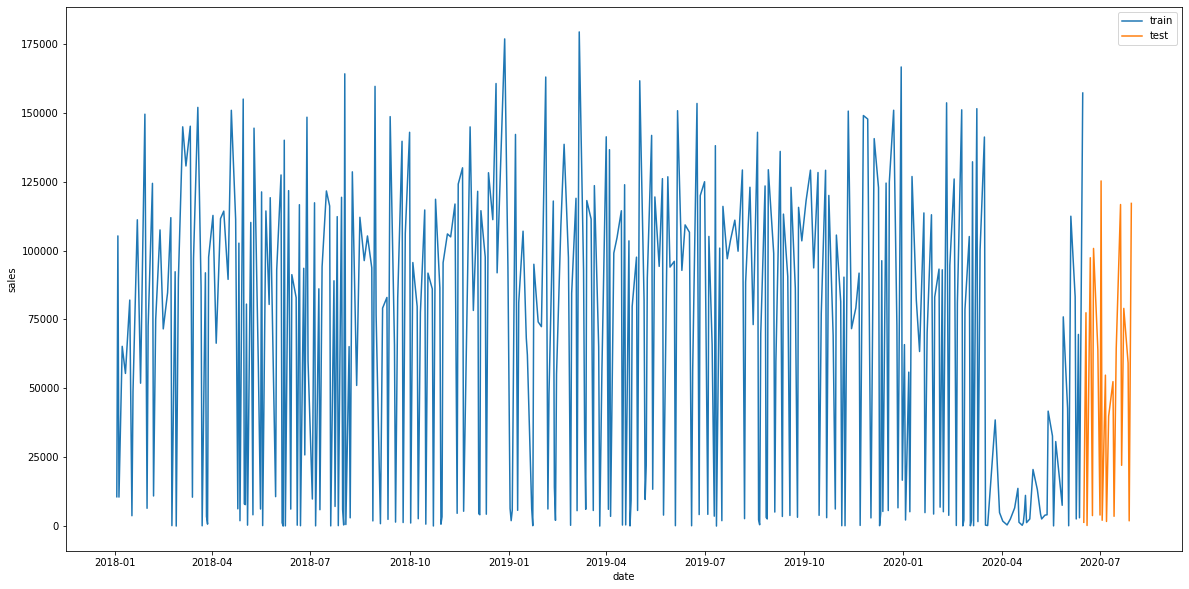

In [ ]:
aggregated=create_features(aggregated)
train, test = split_data(aggregated, '2020-06-15') # splitting the data for training before 15th June

plt.figure(figsize=(20,10))
plt.xlabel('date')
plt.ylabel('sales')
plt.plot(train.index,train['sale_dollars'],label='train')
plt.plot(test.index,test['sale_dollars'],label='test')
plt.legend()
plt.show()

In [ ]:
train.tail(4)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars
date,,,,,,,,,
2020-06-09,1,2,6,2020,161,9,24,1,2588.94
2020-06-11,3,2,6,2020,163,11,24,1,69550.07
2020-06-12,4,2,6,2020,164,12,24,1,3011.43
2020-06-15,0,2,6,2020,167,15,25,1,157158.24


In [ ]:
#!pip install pycaret 

In [ ]:
from pycaret.regression import *

In [ ]:
reg = setup(data = train, 
             target = 'sale_dollars',
             numeric_imputation = 'mean',
             categorical_features = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear',
                                     'flag']  , 
            transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.1,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, 
             silent = True)

,Description,Value
0,session_id,3829
1,Target,sale_dollars
2,Original Data,"(385, 9)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(269, 141)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['dayofweek',
                                                            'quarter', 'month',
                                                            'year', 'dayofyear',
                                                            'dayofmonth',
                                                            'weekofyear',
                                                            'flag'],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='sale_dollars',
                                      time_features=[])),
                ('imputer',
                 Simpl

In [ ]:
# returns best models - takes a little time to run
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,21738.2921,1.192525e+09,33602.2260,0.5514,1.4800,10.2876,0.472
lightgbm,Light Gradient Boosting Machine,22943.0714,1.275093e+09,34928.7690,0.5217,1.5832,11.7785,0.109
gbr,Gradient Boosting Regressor,23274.2145,1.348574e+09,35929.7507,0.4953,1.5691,9.2122,0.098
ada,AdaBoost Regressor,30556.3598,1.819809e+09,42223.0092,0.3302,1.7205,17.9244,0.112
et,Extra Trees Regressor,27265.4391,1.865925e+09,42566.7211,0.3067,1.8818,19.6331,0.521
dt,Decision Tree Regressor,27605.7210,1.885114e+09,42758.2741,0.2994,1.9343,24.0591,0.025
knn,K Neighbors Regressor,37360.8363,2.234013e+09,47015.9990,0.1852,2.1020,52.8049,0.374
lasso,Lasso Regression,53293.7371,3.526851e+09,58832.7586,-0.2847,2.3835,79.6532,0.324
en,Elastic Net,53293.7371,3.526851e+09,58832.7586,-0.2847,2.3835,79.6532,0.562
llar,Lasso Least Angle Regression,53293.7351,3.526851e+09,58832.7595,-0.2847,2.3835,79.6532,0.321


INFO:logs:create_model_container: 10
INFO:logs:master_model_container: 10
INFO:logs:display_container: 2
INFO:logs:[PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                power...
                                regressor=RandomForestRegressor(bootstrap=True,
                                                                ccp_alpha=0.0,
                                                                cri

In [ ]:
#we create a model using light gbm
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,20357.0055,8.699642e+08,29495.1551,0.7073,0.9517,1.7736
1,31740.8150,2.301354e+09,47972.4245,0.1280,1.1851,3.6360
2,16624.6545,5.553884e+08,23566.6802,0.8412,1.8607,12.6080
3,24357.6447,1.546499e+09,39325.5503,0.3690,2.0472,27.3482
4,20490.3004,7.897830e+08,28103.0790,0.6914,1.8585,21.6455
5,23973.1056,1.584156e+09,39801.4602,0.4453,1.6661,3.6654
6,22299.2699,1.067903e+09,32678.7895,0.6072,1.6919,31.2614
7,21335.3631,1.202429e+09,34676.0509,0.5475,1.4505,4.7356
8,21032.9221,8.462584e+08,29090.5205,0.6894,1.6105,8.9406
9,27219.6331,1.987196e+09,44577.9799,0.1901,1.5102,2.1709


INFO:logs:create_model_container: 11
INFO:logs:master_model_container: 11
INFO:logs:display_container: 3
INFO:logs:PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=3...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                  

In [ ]:
tuned_lightgbm = tune_model(lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,26406.4228,1.211939e+09,34812.9115,0.5923,1.1438,2.7495
1,41600.5234,2.999300e+09,54765.8689,-0.1364,1.2205,3.0155
2,26008.5506,1.206696e+09,34737.5260,0.6551,2.1141,18.4260
3,26708.4155,1.675010e+09,40926.8870,0.3165,1.9901,29.5255
4,20266.3925,8.540100e+08,29223.4497,0.6663,1.9358,26.5114
5,30297.7832,1.793294e+09,42347.3041,0.3721,1.8178,10.9774
6,23226.5730,1.036362e+09,32192.5793,0.6188,1.8557,41.1983
7,22329.1863,1.137290e+09,33723.7327,0.5720,1.4896,10.6960
8,19382.1056,7.490365e+08,27368.5319,0.7251,1.7939,13.2169
9,28174.6330,1.826082e+09,42732.6762,0.2558,1.6241,4.6847


INFO:logs:create_model_container: 12
INFO:logs:master_model_container: 12
INFO:logs:display_container: 4
INFO:logs:PowerTransformedTargetRegressor(bagging_fraction=1.0, bagging_freq=3,
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.6,
                                importance_type='split', learning_rate=0.3,
                                max_depth=-1, min_child_samples=31,
                                min_child_weight=0.001, min_split_gain=0.8,
                                n_estimators=130, n_jobs=-1, num_leaves=100,
                                objective=None,
                                power_transformer_method='...
                                                        importance_type='split',
                                                        learning_rate=0.3,
                                                        max_depth=-1,
                                 

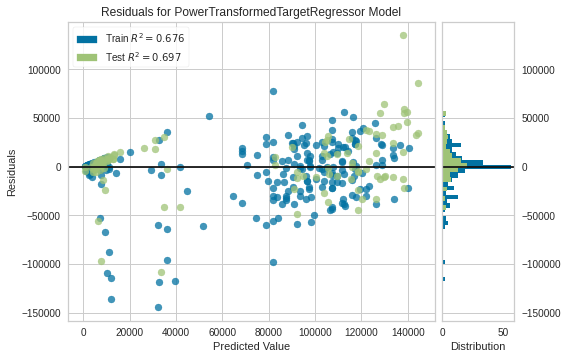

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(lightgbm)

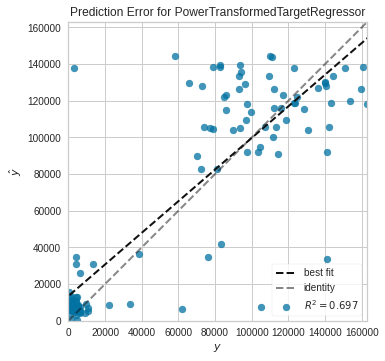

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(lightgbm, plot = 'error')

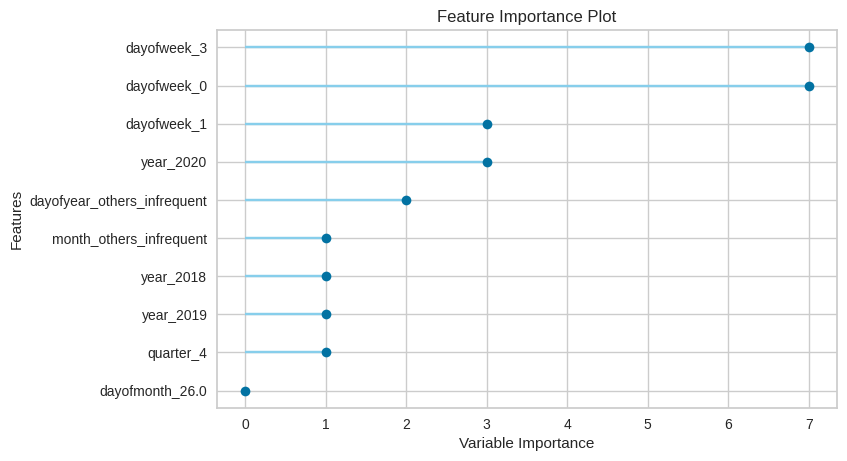

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lightgbm, plot='feature')

In [ ]:
predict_model(tuned_lightgbm);

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(bagging_fraction=1.0, bagging_freq=3,
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.6,
                                importance_type='split', learning_rate=0.3,
                                max_depth=-1, min_child_samples=31,
                                min_child_weight=0.001, min_split_gain=0.8,
                                n_estimators=130, n_jobs=-1, num_leaves=100,
                                objective=None,
                                power_transformer_method='...
                                                        importance_type='split',
                                                        learning_rate=0.3,
                                                        max_depth=-1,
                                                        min_child_samples=3

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,21718.1312,9.344962e+08,30569.5312,0.6886,1.6455,5.4333


In [ ]:
#huber = create_model('huber', verbose = False)
rf = create_model('rf', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=rf, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=False, system=True, metrics=None, display=None, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Random Forest Regressor Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:Uploading model into container now
INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 10
INFO:logs:PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='ms

In [ ]:
tuned_rf = tune_model(rf)
tuned_lightgbm = tune_model(lightgbm)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,26406.4228,1.211939e+09,34812.9115,0.5923,1.1438,2.7495
1,41600.5234,2.999300e+09,54765.8689,-0.1364,1.2205,3.0155
2,26008.5506,1.206696e+09,34737.5260,0.6551,2.1141,18.4260
3,26708.4155,1.675010e+09,40926.8870,0.3165,1.9901,29.5255
4,20266.3925,8.540100e+08,29223.4497,0.6663,1.9358,26.5114
5,30297.7832,1.793294e+09,42347.3041,0.3721,1.8178,10.9774
6,23226.5730,1.036362e+09,32192.5793,0.6188,1.8557,41.1983
7,22329.1863,1.137290e+09,33723.7327,0.5720,1.4896,10.6960
8,19382.1056,7.490365e+08,27368.5319,0.7251,1.7939,13.2169
9,28174.6330,1.826082e+09,42732.6762,0.2558,1.6241,4.6847


INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 16
INFO:logs:PowerTransformedTargetRegressor(bagging_fraction=1.0, bagging_freq=3,
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.6,
                                importance_type='split', learning_rate=0.3,
                                max_depth=-1, min_child_samples=31,
                                min_child_weight=0.001, min_split_gain=0.8,
                                n_estimators=130, n_jobs=-1, num_leaves=100,
                                objective=None,
                                power_transformer_method='...
                                                        importance_type='split',
                                                        learning_rate=0.3,
                                                        max_depth=-1,
                                